## **XGBoost/LightGBM (Time Series Regression)**

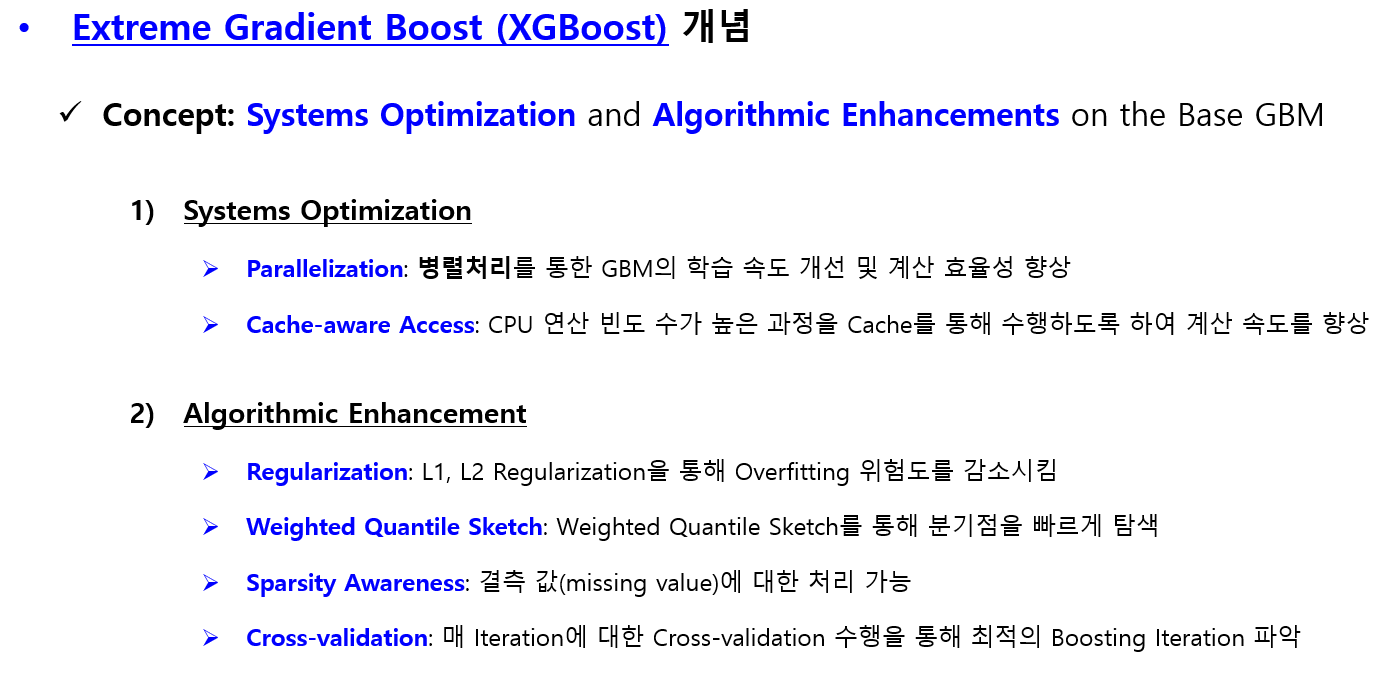

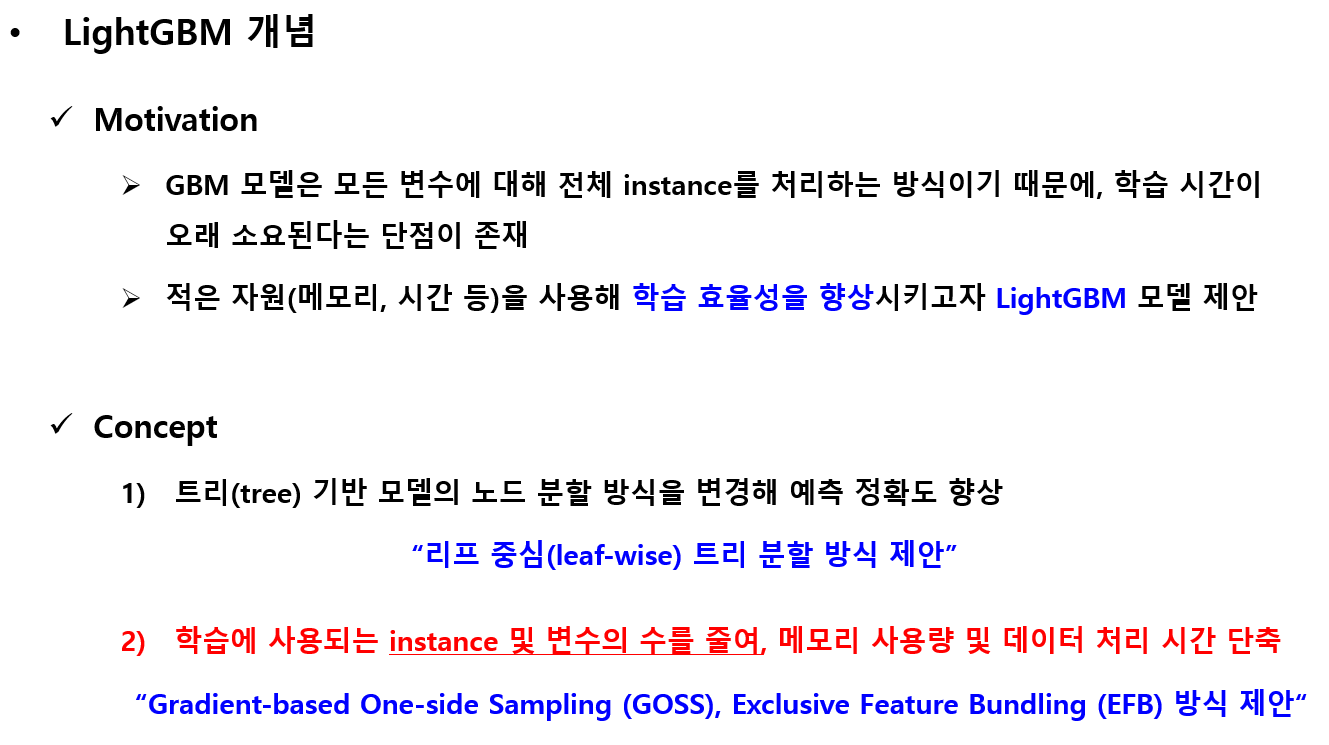

In [ ]:
#import library
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import mean_squared_error as mse

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

In [ ]:
!git clone https://github.com/Yong-Gon/LG2025_Boosting.git #코랩 사용

In [ ]:
# Data import
df = pd.read_csv("/content/LG2025_Boosting/AirQuality.csv")
del df['Unnamed: 0']

df.head()

In [ ]:
# 데이터 프레임 shape 확인
print("shape: ", df.shape)

# 데이터 프레임 변수 타입 확인
print("\ntypes:\n", df.dtypes)

# 데이터 프레임 null 확인
print("\nsum of null:\n", df.isnull().sum())

# 데이터 프레임 분위수(통계량) 확인
print("\nquantiles:\n", df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

- Boxplot

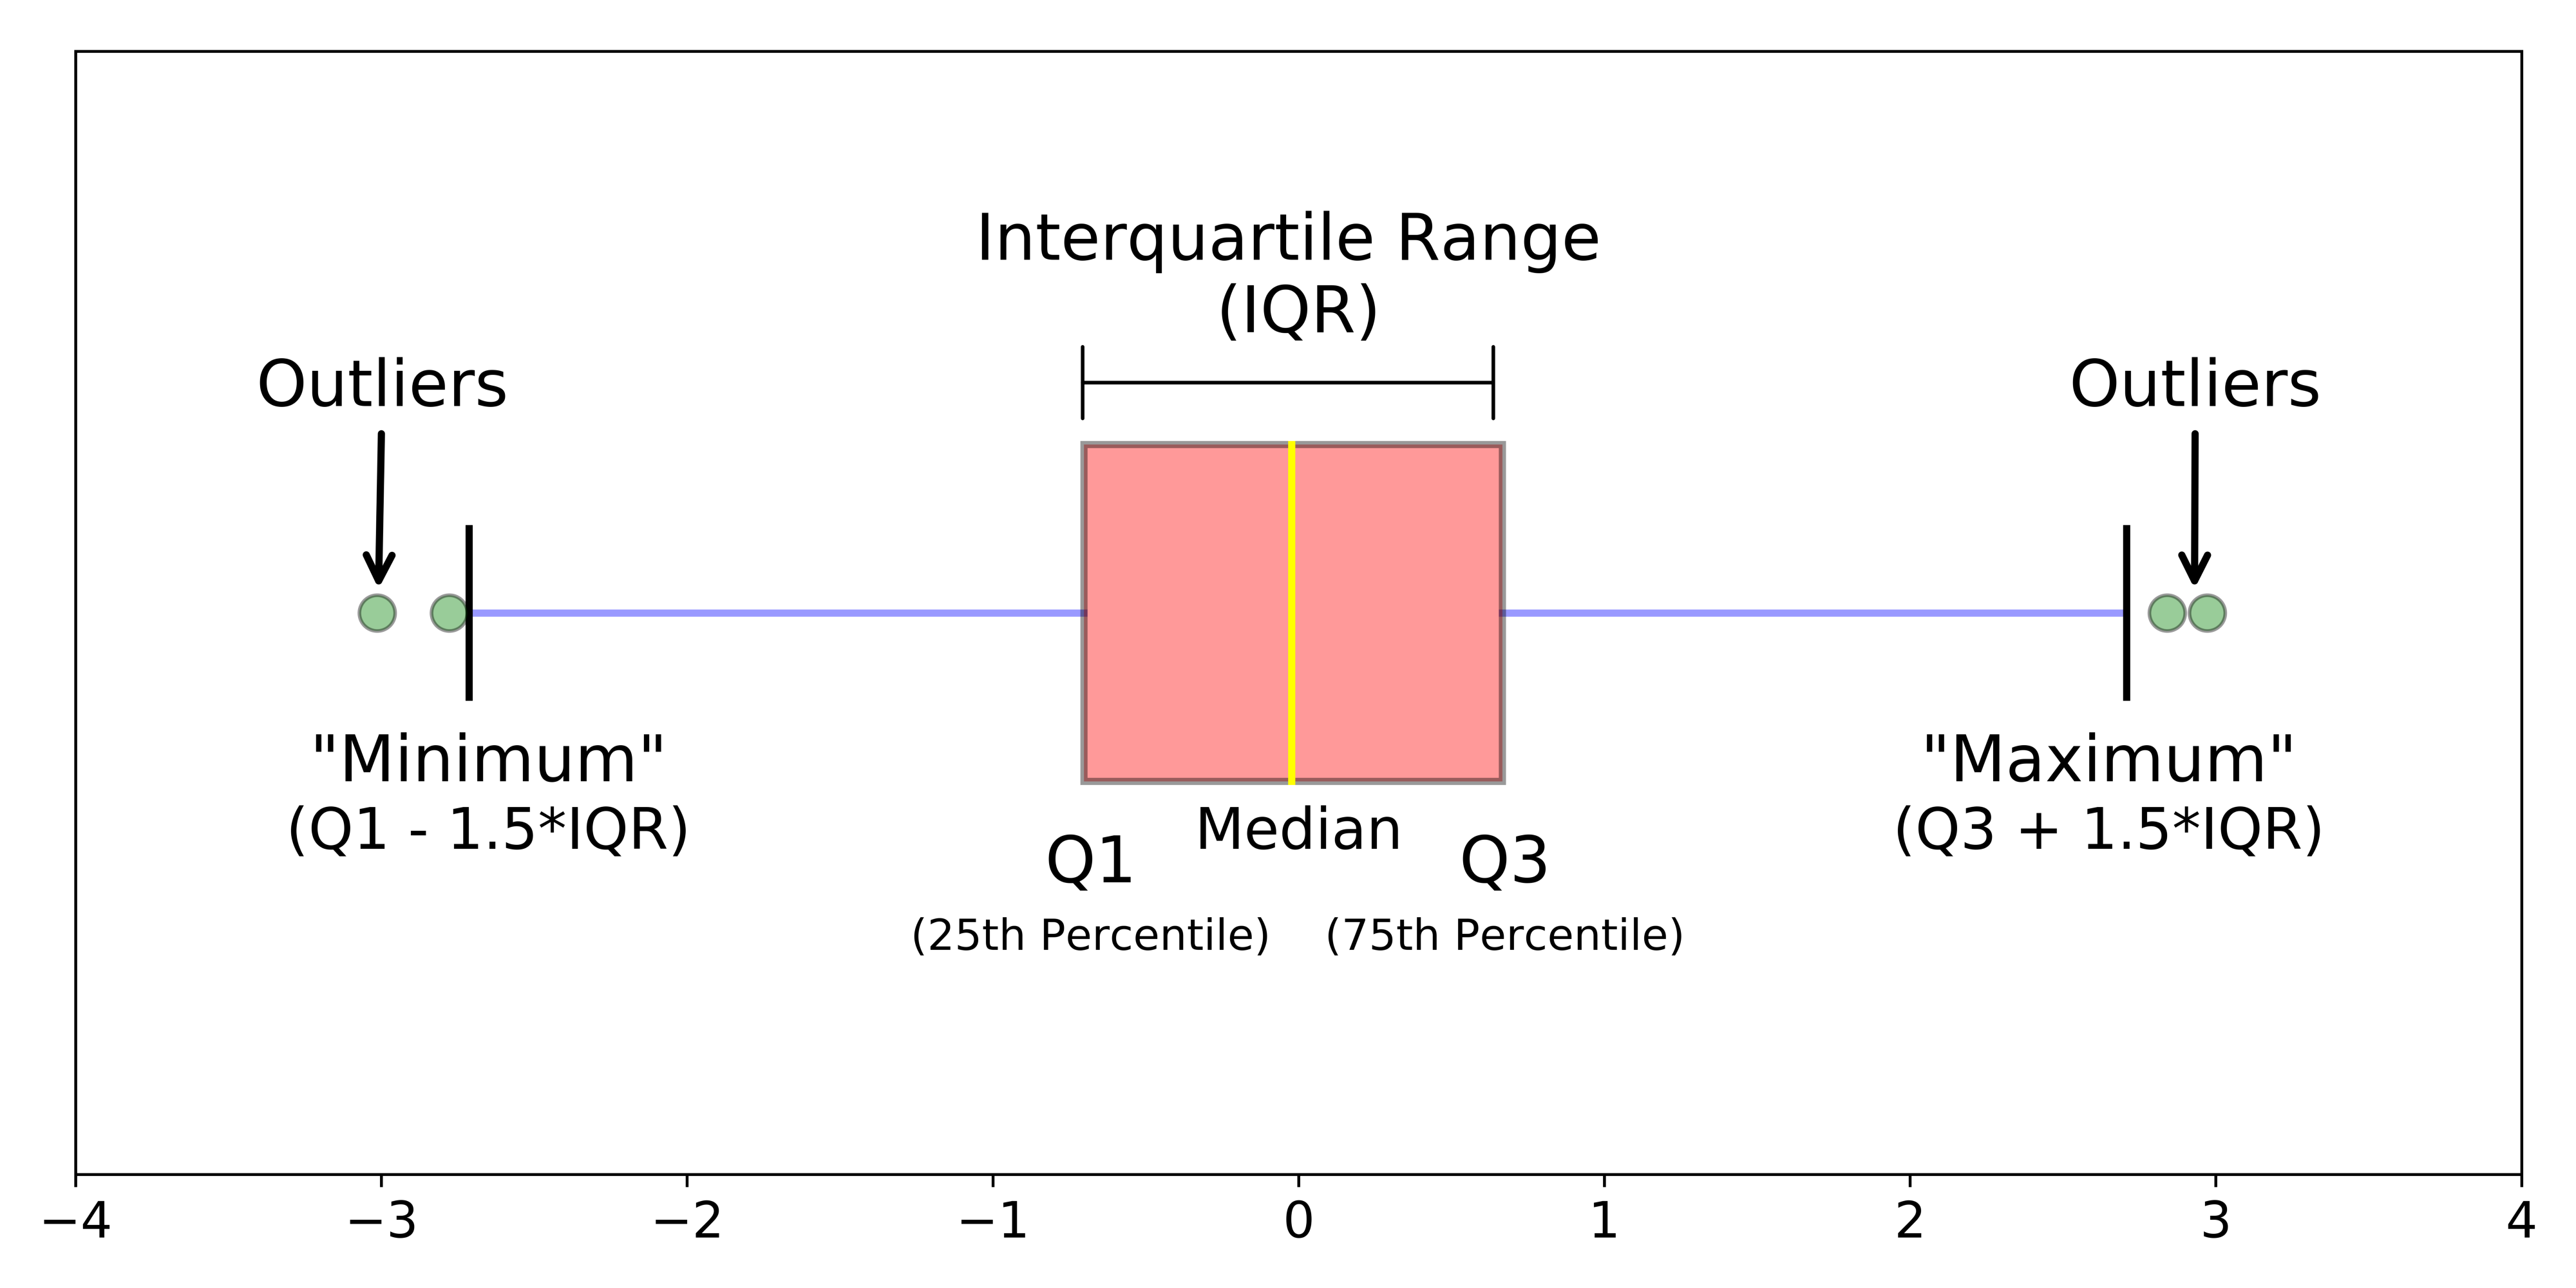

In [ ]:
# IQR method 사용: Q1:0.05%, Q3:0.95%
# for outlier check

def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc) # Q1
    quartile3 = dataframe[col_name].quantile(q3_perc) # Q3
    interquantile_range = quartile3 - quartile1       # IQR

    up_limit = quartile3 + 1.5 * interquantile_range  # UCL
    low_limit = quartile1 - 1.5 * interquantile_range # LCL
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):

    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)

    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

check_outlier(df, 'CO(GT)')

> Feature Engineering

In [ ]:
# select a feature (CO(GT))

name = "CO(GT)"
SIZE = 24

df = df[name]

In [ ]:
# for using t0 ~ t23 (24 times)

COLUMNS = ['t{}'.format(x) for x in range(SIZE)] + ['target']
COLUMNS

In [ ]:
# time series dataframe 구성
time_data = []

for i in range(SIZE, df.shape[0]):
    time_data.append(df.loc[i-SIZE:i].tolist())

time_data = pd.DataFrame(time_data, columns = COLUMNS)
time_data.head()

- Shift 함수 (Lag)

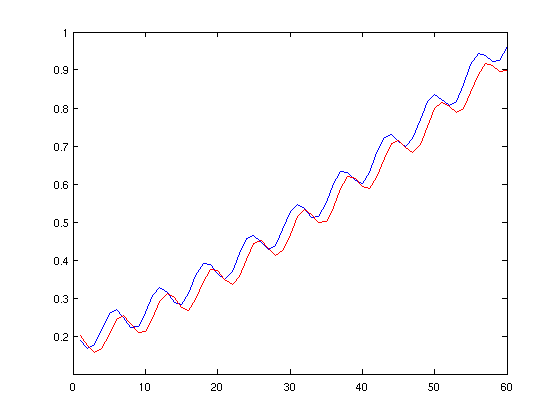

In [ ]:
feats_data = pd.DataFrame()
feats_data['prev_1'] = time_data.iloc[:,-2] # Here -2 as -1 is a target

# feature 생성: mean, median, min, max, std, ewma(mean, last), difference, divide

for win in range(3, 27, 3):
    # select columns by recent times
    tmp = time_data.iloc[:,-1-win:-1]
    print("window: ", win)
    print("\ntmp shape:\n", tmp.shape)

    #General statistics for base level
    feats_data['mean_prev_{}'.format(win)] = tmp.mean(axis=1) # mean
    feats_data['median_prev_{}'.format(win)] = tmp.median(axis=1) # median
    feats_data['min_prev_{}'.format(win)] = tmp.min(axis=1) # min
    feats_data['max_prev_{}'.format(win)] = tmp.max(axis=1) # max
    feats_data['std_prev_{}'.format(win)] = tmp.std(axis=1) # standard deviation

    #Capturing trend
    feats_data['mean_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1) # ewm; Exponential Moving Average
    feats_data['last_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1]

    feats_data['avg_diff_{}'.format(win)] = (tmp - tmp.shift(1, axis=1)).mean(axis=1)
    feats_data['avg_div_{}'.format(win)] = (tmp / tmp.shift(1, axis=1)).mean(axis=1)

In [ ]:
tmp.head()

In [ ]:
feats_data.head()

In [ ]:
# 일주일(7일) 간격 특성을 활용하기 위한 feature 생성
for win in [2, 3, 4]:

    tmp = time_data.iloc[:,-1-win*6:-1:6] # row, col, step
    print("window: ", win)
    print("\ntmp shape:\n", tmp.shape)

    #Features for weekly seasonality
    feats_data['6days_mean_prev_{}'.format(win)] = tmp.mean(axis=1)
    feats_data['6days_median_prev_{}'.format(win)] = tmp.median(axis=1)
    feats_data['6days_min_prev_{}'.format(win)] = tmp.min(axis=1)
    feats_data['6days_max_prev_{}'.format(win)] = tmp.max(axis=1)
    feats_data['6days_std_prev_{}'.format(win)] = tmp.std(axis=1)

feats_data = pd.concat([feats_data, time_data.iloc[:, -1]], axis = 1)

In [ ]:
tmp.head()

In [ ]:
feats_data.head()

In [ ]:
# split train and test data
train_data      = feats_data.iloc[0:8000, :]
validation_data = feats_data.iloc[8000:9000, :] # 제거
test_data       = feats_data.iloc[9000:, :]

X_train = train_data.iloc[:, :-1]; Y_train = train_data.iloc[:, -1]
X_test  = test_data.iloc[:, :-1];  Y_test  = test_data.iloc[:, -1]

## Model 1. XGBoost

In [ ]:
from xgboost import XGBRegressor

'''
Parameter 참고: https://xgboost.readthedocs.io/en/stable/parameter.html
'''

model_XG = XGBRegressor(learning_rate    = 0.3,
                        max_depth        = 6)

model_XG.fit(X_train, Y_train, eval_metric="error", early_stopping_rounds = 10, eval_set=[(X_test, Y_test)], verbose=True)

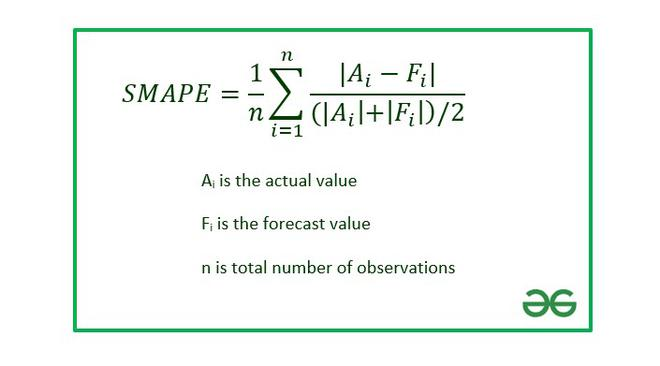

In [ ]:
# SMAPE (Symmetric Mean Absolute Percentage Error) 평가지표 사용

def smape(preds, target):

    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def val_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
# testset의 Sales 값 예측 (log value)
pred_XG = model_XG.predict(X_test)

# 평가지표
print("SMPE : ", smape(np.expm1(pred_XG), np.expm1(Y_test)))
print("R-squared: ", model_XG.score(X_train, Y_train))

In [ ]:
# 예측 값과 실제 값 비교
plt.figure(figsize = (15, 5))
plt.plot(Y_test.values, label = 'true value')
plt.plot(pred_XG, label = 'predicted value')
plt.legend()
plt.show()

## Model 2. LightGBM

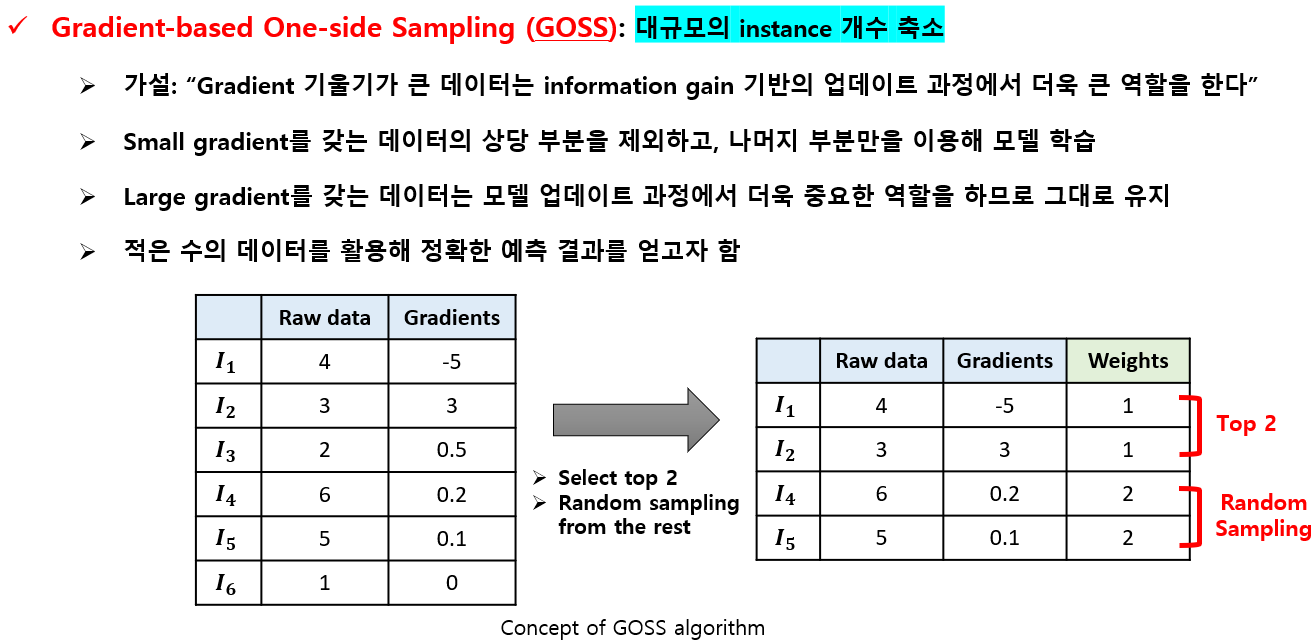

In [ ]:
from lightgbm import LGBMRegressor
'''
Parameter 참고: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

boosting type:
    'gbdt' (traditional Gradient Boosting Decision Tree), 'dart' (Multiple Additive Regression Trees), 'goss' (Gradient-based One-side Sampling), 'rf' (Random Forest)
'''
model_LGBM = LGBMRegressor(learning_rate    = 0.01,
                           boosting_type    = 'goss',
                           feature_fraction = 0.5,
                           max_depth        = 10,
                           verbose          = 0,
                           num_boost_rounds = 15000)

model_LGBM.fit(X_train, Y_train, eval_metric="error", eval_set=[(X_test, Y_test)])

In [ ]:
# testset의 Sales 값 예측 (log value)
pred_LGBM = model_LGBM.predict(X_test)

# 평가지표
print("SMPE : ", smape(np.expm1(pred_LGBM), np.expm1(Y_test)))
print("R-squared: ", model_LGBM.score(X_train, Y_train))

In [ ]:
# 예측 값과 실제 값 비교
plt.figure(figsize = (15, 5))
plt.plot(Y_test.values, label = 'true value')
plt.plot(pred_LGBM, label = 'predicted value')
plt.legend()
plt.show()

In [ ]:
# 변수중요도 계산

lgb.plot_importance(model_LGBM, max_num_features=20, figsize=(10, 7), importance_type="gain")
plt.show()